## Data Preprocessing

In [ ]:
# Import the required libraries for data preprocessing & the CNN project implementation
from google.colab import drive
import pickle
import numpy as np
import random
import os
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from concurrent.futures import ThreadPoolExecutor
from tensorflow.keras.preprocessing.image import load_img, img_to_array

In [ ]:
# Mount the google drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Paths to the folders containing images of the different cell types
platelet_dir = '/content/drive/MyDrive/cnn_blood_type/bloodcells_dataset/platelet'
neutrophil_dir = '/content/drive/MyDrive/cnn_blood_type/bloodcells_dataset/neutrophil'
monocyte_dir = '/content/drive/MyDrive/cnn_blood_type/bloodcells_dataset/monocyte'
lymphocyte_dir = '/content/drive/MyDrive/cnn_blood_type/bloodcells_dataset/lymphocyte'
ig_dir = '/content/drive/MyDrive/cnn_blood_type/bloodcells_dataset/ig'
erythroblast_dir = '/content/drive/MyDrive/cnn_blood_type/bloodcells_dataset/erythroblast'
eosinophil_dir = '/content/drive/MyDrive/cnn_blood_type/bloodcells_dataset/eosinophil'
basophil_dir = '/content/drive/MyDrive/cnn_blood_type/bloodcells_dataset/basophil'

# List of class labels
class_labels = ['platelet', 'neutrophil', 'monocyte', 'lymphocyte', 'ig', 'erythroblast', 'eosinophil', 'basophil']
dir_list = [platelet_dir, neutrophil_dir, monocyte_dir, lymphocyte_dir, ig_dir, erythroblast_dir, eosinophil_dir, basophil_dir]

In [ ]:
# Initialize a list to store the image file paths
paths = []
# Initialize a list to store the image labels
labels = []

# Loop over each dir in the dir_list
for class_index, dir in enumerate(dir_list):
  # Get all the image files in the current dir
  for img_name in os.listdir(dir):
    # Create a full path
    img_path = os.path.join(dir, img_name)
    # Add the image path to the paths list
    paths.append(img_path)
    # Add the class labels to the labels list
    labels.append(class_labels[class_index])

In [ ]:
print("dataframe:")
df = pd.DataFrame({'path': paths, 'label': labels})
print(df.head())

print("\nlabel counts:")
label_count = df['label'].value_counts()
print(label_count.to_string())

print("\ndataframe shape:")
print(df.shape)

dataframe:
                                                path     label
0  /content/drive/MyDrive/cnn_blood_type/bloodcel...  platelet
1  /content/drive/MyDrive/cnn_blood_type/bloodcel...  platelet
2  /content/drive/MyDrive/cnn_blood_type/bloodcel...  platelet
3  /content/drive/MyDrive/cnn_blood_type/bloodcel...  platelet
4  /content/drive/MyDrive/cnn_blood_type/bloodcel...  platelet

label counts:
label
neutrophil      3339
eosinophil      3117
ig              2895
platelet        2358
erythroblast    1551
monocyte        1420
basophil        1218
lymphocyte      1214

dataframe shape:
(17112, 2)


In [ ]:
print("balanced dataframe:")
groups = df.groupby('label')

# Randomly select 1200 images from the dataset to balance the classes
balanced_df = pd.concat(
    [sub.sample(1200, random_state=1) for label_name, sub in groups]
).reset_index(drop=True)

# Shuffle this balanced_df before passing it onto the model for training and testing
balanced_df = balanced_df.sample(frac=1, random_state=1).reset_index(drop=True)

print(balanced_df.head())

print("\nlabel counts:")
print(balanced_df['label'].value_counts())

print("\nbalanced dataframe shape:")
print(balanced_df.shape)

balanced dataframe:
                                                path       label
0  /content/drive/MyDrive/cnn_blood_type/bloodcel...    platelet
1  /content/drive/MyDrive/cnn_blood_type/bloodcel...  eosinophil
2  /content/drive/MyDrive/cnn_blood_type/bloodcel...  lymphocyte
3  /content/drive/MyDrive/cnn_blood_type/bloodcel...  neutrophil
4  /content/drive/MyDrive/cnn_blood_type/bloodcel...    basophil

label counts:
label
platelet        1200
eosinophil      1200
lymphocyte      1200
neutrophil      1200
basophil        1200
erythroblast    1200
monocyte        1200
ig              1200
Name: count, dtype: int64

balanced dataframe shape:
(9600, 2)


In [ ]:
# map the class indices to labels
mapping = dict(enumerate(class_labels))

print("mapping:")
for i, label in enumerate(class_labels):
    print(f'label {i}: {mapping[i]}')

mapping:
label 0: platelet
label 1: neutrophil
label 2: monocyte
label 3: lymphocyte
label 4: ig
label 5: erythroblast
label 6: eosinophil
label 7: basophil


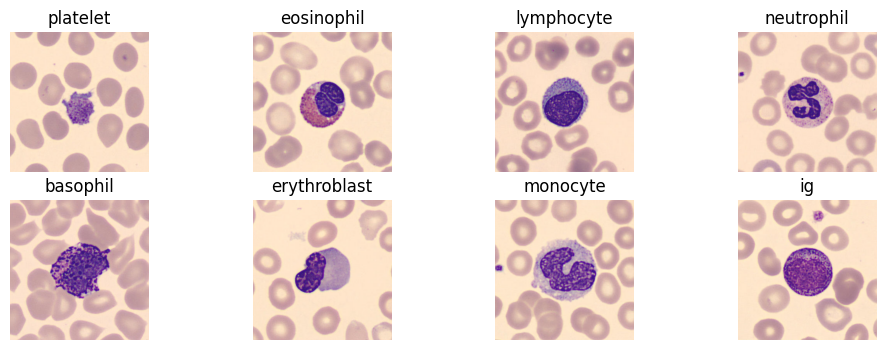

In [ ]:
# Display the 8 different cell class types from the balanced_df
def display_first_imgs(balanced_df):
    class_names = balanced_df['label'].unique()
    imgs_per_class = {}

    for class_name in class_names:
        img_path = balanced_df[balanced_df['label'] == class_name]['path'].iloc[0]
        img = load_img(img_path)
        imgs_per_class[class_name] = img

    plt.figure(figsize=(12, 4))
    for i, (class_name, img) in enumerate(imgs_per_class.items()):
        plt.subplot(2, 4, i + 1)
        plt.imshow(img)
        plt.title(class_name)
        plt.axis('off')
    plt.show()

display_first_imgs(balanced_df)

In [ ]:
def load_imgs(path):
    # Load and resize images to 64x64 and then normalize them
    img = load_img(path, target_size=(64, 64))
    img = img_to_array(img) / 255.0
    return img

def preprocess_imgs(balanced_df):
    global no_of_classes, lr
    # Learning rate
    lr = 0.0001
    # Number of classes (8 blood cell types)
    no_of_classes = 8

    # Retreive image paths and labels
    img_paths = balanced_df['path'].values
    labels = balanced_df['label'].values

    # Load images using multiple threads
    with ThreadPoolExecutor() as executor:
        imgs = list(executor.map(load_imgs, img_paths))

    # Convert the blood images to a numpy array
    imgs = np.array(imgs, dtype='float32')
    # One-hot encode the labels
    labels = pd.get_dummies(labels).values

    print("Images shape:", imgs.shape)
    print("Labels shape after one-hot encoding:", labels.shape)

    # Split into training and testing sets - 80% training and 20% testing
    train_x, test_x, train_y, test_y = train_test_split(imgs, labels, test_size=0.2, random_state=1)

    return (train_x, train_y), (test_x, test_y)

(train_x, train_y), (test_x, test_y) = preprocess_imgs(balanced_df)

Images shape: (9600, 64, 64, 3)
Labels shape after one-hot encoding: (9600, 8)


In [ ]:
print(f'training subset shape - {train_x.shape}, {train_y.shape}')
print(f'testing subset shape - {test_x.shape}, {test_y.shape}')

training subset shape - (7680, 64, 64, 3), (7680, 8)
testing subset shape - (1920, 64, 64, 3), (1920, 8)


In [ ]:
print("labels -", len(np.unique(labels)))

labels - 8


## Model Architecture

In [ ]:
class conv_2d_layer:
    weights = None
    biases = None
    step = None
    padding_size = None
    input_act = None

    def __init__(self, step, padding_size):
        self.step = step
        self.padding_size = padding_size

    def zero_pad(self, input):
        # Pad the input image with zeros on all edges...
        padded = np.pad(input, ((0, 0), (self.padding_size, self.padding_size), (self.padding_size, self.padding_size), (0, 0)), 'constant', constant_values=0)
        return padded

    def single_step(self, act_slice, filter_weights, filter_biases):
        # Single conv using weights and biases
        m = np.multiply(act_slice, filter_weights)
        # Sum over all dims
        s = np.sum(m, axis=(1, 2, 3))
        # Remove single dims entries
        filter_biases = np.squeeze(filter_biases)
        # Add the biases to the sum
        r = s + filter_biases
        return r

    def forward(self, input_act):
        # Forward pass...
        (x, height_prev, width_prev, channels_prev) = input_act.shape
        (filter_size, filter_size, channels_prev, channels) = self.weights.shape

        # Calculate output dims
        height = int((height_prev + 2 * self.padding_size - filter_size) / self.step) + 1
        width = int((width_prev + 2 * self.padding_size - filter_size) / self.step) + 1

        # Initialize the output
        output  = np.zeros((x, height, width, channels))
        # Add zero padding to the input blood image
        input_act_pad = self.zero_pad(input_act)

        for h in range(height):
            v_start = self.step * h
            v_end = v_start + filter_size
            for w in range(width):
                h_start = self.step * w
                h_end = h_start + filter_size
                for c in range(channels):

                    # Get the current slice
                    act_slice_prev = input_act_pad[:, v_start:v_end, h_start:h_end, :]
                    # Get weights
                    weights = self.weights[:, :, :, c]
                    # Get biases
                    biases = self.biases[:, :, :, c]
                    # Single conv step
                    output[:, h, w, c] = self.single_step(act_slice_prev, weights, biases)

        # Store the input for backpropagation later on
        self.input_act = input_act

        # Return the output of conv
        return output

    def initialize(self, filter_size, channels_in, channels_out, prev_input_size):
        # Initialize weights and biases
        self.weights = np.random.randn(filter_size, filter_size, channels_in, channels_out) * np.sqrt(2 / prev_input_size)
        self.biases = np.zeros((1, 1, 1, channels_out))


    def backward(self, d_output, lr=0.001):
        # Backpropagation
        # Get the input dims
        (x, height_prev, width_prev, channels_prev) = self.input_act.shape
        # Get the filter dims
        (filter_size, filter_size, channels_prev, channels) = self.weights.shape
        # Get the output dims
        (x, height, width, channels) = d_output.shape

        # Initialize the gradients for input, weights, and biases
        d_input_act = np.zeros((self.input_act.shape))
        d_weights = np.zeros(self.weights.shape)
        d_biases = np.zeros(self.biases.shape)

        # Pad input for backpropagation
        input_act_pad = self.zero_pad(self.input_act)
        # Pad gradient for backpropagation
        d_input_act_pad = self.zero_pad(d_input_act)

        for h in range(height):
            for w in range(width):
                for c in range(channels):
                    v_start = self.step * h
                    v_end = v_start + filter_size
                    h_start = self.step * w
                    h_end = h_start + filter_size

                    # Get the current input slice
                    act_slice = input_act_pad[:, v_start:v_end, h_start:h_end, :]
                    # Update graidents
                    d_input_act_pad[:, v_start:v_end, h_start:h_end, :] += self.weights[np.newaxis, :, :, :, c] * d_output[:, h:h + 1, w:w + 1, np.newaxis, c]
                    d_weights[:, :, :, c] += np.sum(act_slice * d_output[:, h:h + 1, w:w + 1, np.newaxis, c], axis=0)
                    d_biases[:, :, :, c] += np.sum(d_output[:, h, w, c])

        if self.padding_size != 0:
            # Remove padding from the gradient of the input
            d_input_act = d_input_act_pad[:, self.padding_size:-self.padding_size, self.padding_size:-self.padding_size, :]
        else:
            d_input_act = d_input_act_pad

        # Update these weights and biases using gradients
        self.weights -= lr * d_weights
        self.biases -= lr * d_biases

        return d_input_act

In [ ]:
class pool_2d_layer:
    filter_size = None
    step = None
    input_act = None

    def __init__(self, filter_size, step):
        self.filter_size = filter_size
        self.step = step

    def forward(self, input_act):
        # Get the input dims
        (x, height_prev, width_prev, channels_prev) = input_act.shape

        # Calculate output height and width
        height = int(1 + (height_prev - self.filter_size) / self.step)
        width = int(1 + (width_prev - self.filter_size) / self.step)
        channels = channels_prev

        # Initialize output array
        output = np.zeros((x, height, width, channels))

        # Apply max pooling
        for h in range(height):
            v_start = self.step * h
            v_end = v_start + self.filter_size
            for w in range(width):
                h_start = self.step * w
                h_end = h_start + self.filter_size
                act_slice = input_act[:, v_start:v_end, h_start:h_end, :]
                # Max pooling
                output[:, h, w, :] = np.max(act_slice, axis=(1, 2))
        self.input_act = input_act
        return output

    def backward(self, d_output):
        # Get the input dims
        x, height_prev, width_prev, channels_prev = self.input_act.shape
        # Get output dims
        x, height, width, channels = d_output.shape
        # Initialize gradient
        d_input_act = np.zeros(self.input_act.shape)

        # Backpropagate throught the max pooling layers
        for h in range(height):
            for w in range(width):
                for c in range(channels):
                    v_start = h * self.step
                    v_end = h * self.step + self.filter_size
                    h_start = w * self.step
                    h_end = w * self.step + self.filter_size

                    # Input slice
                    act_slice = self.input_act[:, v_start:v_end, h_start:h_end, c]
                    # Create a mask for the max pooling values
                    mask = (act_slice == np.amax(act_slice, axis=(1, 2)).reshape(act_slice.shape[0], 1, 1))
                    # Scale gradients
                    d_input_act[:, v_start:v_end, h_start:h_end, c] += (mask * d_output[:, h:h + 1, w:w + 1, c])

        return d_input_act

In [ ]:
class relu:
    def __init__(self):
        self.input_cache = None

    def forward(self, x):
        # Store the input
        self.input_cache = x
        # Apply ReLU act function, only outputting positive values
        return np.maximum(x, 0)

    def backward(self, d_output):
        # Create the ReLU gradient for backpropagation
        d_relu = np.where(self.input_cache > 0, 1, 0)
        # Multiply...
        return d_relu * d_output

In [ ]:
class flat:
    def __init__(self):
        # Store the original shape
        self.original_shape = None

    def forward(self, input):
        # Store the original shape of the input blood images
        self.original_shape = input.shape
        # Compute the total num of elements for flattening
        flatten_dim = np.prod(input.shape)
        # Initialize output array for the flattened blood images
        flatten_dim = int(flatten_dim / input.shape[0])
        output = np.empty((input.shape[0], flatten_dim))

        # Flatten each image and store in the newly created output array
        for i, item in enumerate(input):
            flat = item.flatten()
            output[i, :] = flat
        # Return then transposed output
        return output.T

    def backward(self, input):
        # Transpose...
        flat = input.T
        # Reshape back to the original image
        flat = flat.reshape(self.original_shape)
        return flat

In [ ]:
class dropout:
    def __init__(self, dropout_rate):
        # Initialize the dropout rate
        self.dropout_rate = dropout_rate
        self.mask = None

    def forward(self, A, training=True):
        # Only apply dropout during training...
        if training:
            # Randomly select neuorns to retain
            self.mask = (np.random.rand(*A.shape) > self.dropout_rate)
            # Apply the mask to the input
            A_dropout = A * self.mask
            return A_dropout
        # If not training, return the input without dropout
        else:
            return A

    def backward(self, dA):
        # Scale the gradient
        if self.mask is not None:
            return dA * self.mask
        return dA

In [ ]:
class fully_connected_layer:
    weights = None
    biases = None
    input_act = None

    def __init__(self):
        pass

    def forward(self, act):
        # Calculate output using both weights and biases
        output = np.dot(self.weights, act) + self.biases
        # Store the input blood images for backpropagation
        self.input_act = act
        return output

    def initialize(self, output_dim, input_dim):
        # Initialize weights and biases
        self.weights = np.random.randn(output_dim, input_dim) * np.sqrt(2 / input_dim)
        self.biases = np.zeros((output_dim, 1))

    def backward(self, d_output, lr=0.001):
        # Get the num of blood type images
        x = self.input_act.shape[1]

        # Calculate the gradients for the weights and biases
        d_weights = (1 / x) * np.dot(d_output, self.input_act.T)
        d_biases = (1 / x) * np.sum(d_output, axis=1, keepdims=True)

        # Now calculate the gradient for the input blood images
        d_input_act = np.dot(self.weights.T, d_output)

        # Update...
        self.weights = self.weights - (d_weights * lr)
        self.biases = self.biases - (d_biases * lr)
        return d_input_act

In [ ]:
class softmax:
    def __init__(self):
        pass

    def forward(self, x):
        # Subtract the max for stability
        x -= np.amax(x, axis=0)
        # Calculate exponentials
        x_1 = np.exp(x)
        # Normalize to get the probabilities
        x_2 = x_1 / np.sum(x_1, axis=0)
        return x_2

    def backward(self, y, y_hat):
        # Calculate the gradient of the loss...transposing as well
        return (y_hat - y).T

## Training and Evaluation

In [ ]:
def main():
    # Preprocess the images from the balanced_df, splitting into training and testing subsets
    (train_x, train_y), (test_x, test_y) = preprocess_imgs(balanced_df)

    # Link to the architecture text file...which will be used to initialize the layers
    architecture = "/content/drive/MyDrive/cnn_blood_type/input.txt"

    # Create the CNN using the pre-defined layers in the text file above
    layers = build_cnn(architecture, train_x)

    # Save
    model_save = '/content/drive/MyDrive/cnn_blood_type/model_with_outputs.pkl'

    # Train the model and evaluate its performance on the split training and testing datasets
    train_evaluate(layers, train_x, train_y, test_x, test_y, model_save)

In [ ]:
def build_cnn(architecture, train_x):

  # Read the CNN architecture
  try:
      with open(architecture, 'r') as input_file:
          lines = input_file.readlines()
  except FileNotFoundError:
      print("The file containing the 'CNN architecture' was not found.")
      return

  # Store the CNN layers
  layers = []
  z = train_x[:2].copy()

  # Scan over each line in the architecture file
  for line in lines:
    # Split the lines up into sections
    items = line.split()

    if items[0] == 'Conv':
        num_out_channels = int(items[1])
        filter_size = int(items[2])
        step = int(items[3])
        padding_size = int(items[4])
        c = conv_2d_layer(step, padding_size)
        c.initialize(filter_size, z.shape[-1], num_out_channels, np.size(z[0]))
        z = c.forward(z)
        layers.append(c)
        continue

    if items[0] == 'ReLU':
        r = relu()
        z = r.forward(z)
        layers.append(r)
        continue

    if items[0] == 'Dropout':
        dropout_rate = float(items[1])
        d = dropout(dropout_rate)
        z = d.forward(z)
        layers.append(d)
        continue

    if items[0] == 'Pool':
        pool_filter_size = int(items[1])
        step = int(items[2])
        p = pool_2d_layer(pool_filter_size, step)
        z = p.forward(z)
        layers.append(p)
        continue

    if items[0] == 'Flatten':
        f = flat()
        z = f.forward(z)
        layers.append(f)
        continue

    if items[0] == 'FC':
        output_dim = int(items[1])
        fc = fully_connected_layer()
        fc.initialize(output_dim, z.shape[0])
        z = fc.forward(z)
        layers.append(fc)
        continue

    if items[0] == 'Softmax':
        s = softmax()
        z = s.forward(z)
        layers.append(s)
        continue

  return layers

In [ ]:
def lr_update(epoch, initial_lr, final_lr, epochs):
  # Decay rate
  decay_rate = np.log(final_lr / initial_lr) / epochs
  # Return the updated lr
  return initial_lr * np.exp(decay_rate * epoch)

In [ ]:
def train_evaluate(layers, train_x, train_y, test_x, test_y, model_save):
    totaldata = train_x.shape[0]
    validationdata = int(test_x.shape[0] / 2)

    batchsize = 64
    total_epochs = 20
    no_of_classes = 8

    global lr
    initial_lr = 0.01
    lr = initial_lr
    final_lr = 0.0001

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    # Training
    for i in range(total_epochs):
        learning_rate = lr_update(i, initial_lr, final_lr, total_epochs)
        print(f"Epoch {i + 1} - Learning Rate: {learning_rate}")

        idx = 0
        flag = False

        while True:
            if idx + batchsize >= totaldata:
                flag = True
                x_batch = train_x[idx:]
                yt_batch = train_y[idx:]
            else:
                x_batch = train_x[idx:idx + batchsize]
                yt_batch = train_y[idx:idx + batchsize]
            idx += batchsize

            z = x_batch.copy()

            for layer in layers:
                if isinstance(layer, dropout):
                    z = layer.forward(z, training=True)
                else:
                    z = layer.forward(z)
            z = z.T

            yt_batch = np.argmax(yt_batch, axis=1)

            y = np.zeros((x_batch.shape[0], no_of_classes))

            try:
                y[np.arange(x_batch.shape[0]), yt_batch] = 1
            except IndexError as e:
                print(f"IndexError during one-hot encoding: {e}")
                raise

            dA = None
            for layer in reversed(layers):
                if isinstance(layer, softmax):
                    dA = layer.backward(y, z)
                elif isinstance(layer, conv_2d_layer) or isinstance(layer, fully_connected_layer):
                    dA = layer.backward(dA, learning_rate)
                else:
                    dA = layer.backward(dA)

            if flag:
                break

            predictions = np.argmax(z, axis=1)
            batch_accuracy = np.mean(predictions == yt_batch)

            if idx // batchsize % 10 == 0:
                print(f"Batch {idx // batchsize}, Training Loss: {cross_entropy_loss(z, y)}, Accuracy: {batch_accuracy * 100:.2f}%")

        print("------------Epoch ", i + 1, "-------------")

        # Calculate training loss and accuracy
        z = train_x.copy()
        # One-hot encoded labels back to class indices
        yt = np.argmax(train_y, axis=1).flatten()

        for layer in layers:
            if isinstance(layer, dropout):
                z = layer.forward(z, training=True)
            else:
                z = layer.forward(z)
        z = z.T

        y = np.zeros((yt.size, no_of_classes))
        y[np.arange(yt.size), yt] = 1
        train_loss = cross_entropy_loss(z, y)
        train_losses.append(train_loss)

        # Calculate accuracy
        train_accuracy = np.mean(np.argmax(z, axis=1) == yt)
        train_accuracies.append(train_accuracy)
        print("Training Loss: ", train_loss)
        print("Training Accuracy: {:.2f}%".format(train_accuracy * 100))

        # Calculate val loss and accuracy
        z = test_x[:validationdata].copy()
        # One-hot encoded labels back to class indices
        yt = np.argmax(test_y[:validationdata], axis=1).flatten()

        for layer in layers:
            if isinstance(layer, dropout):
                z = layer.forward(z, training=True)
            else:
                z = layer.forward(z)
        z = z.T

        y = np.zeros((yt.size, no_of_classes))
        y[np.arange(yt.size), yt] = 1
        val_loss = cross_entropy_loss(z, y)
        val_losses.append(val_loss)
        # Calculate val accuracy
        val_accuracy = np.mean(np.argmax(z, axis=1) == yt)
        val_accuracies.append(val_accuracy)
        print("Validation Loss: ", val_loss)
        print("Validation Accuracy: {:.2f}%".format(val_accuracy * 100))

    # Evaluating loss in training and val
    plt.figure(figsize=(10, 5))
    plt.plot(train_losses, label='Training Loss', color='blue')
    plt.plot(val_losses, label='Validation Loss', color='orange')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

    # Evaluating accuracy in training and val
    plt.figure(figsize=(10, 5))
    plt.plot(train_accuracies, label='Training Accuracy', color='blue')
    plt.plot(val_accuracies, label='Validation Accuracy', color='orange')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    # Testing on unseen data
    print("--------------Test Set--------------")
    z = test_x[validationdata:].copy()
    yt = np.argmax(test_y[validationdata:], axis=1).flatten()

    for layer in layers:
        if isinstance(layer, dropout):
            z = layer.forward(z, training=False)
        else:
            z = layer.forward(z)
    z = z.T

    y = np.zeros((yt.size, no_of_classes))
    y[np.arange(yt.size), yt] = 1
    test_loss = cross_entropy_loss(z, y)
    print("Loss : ", test_loss)
    yp = z.argmax(axis=1)

    model_output = {
        'model': layers,
        'train_losses': train_losses,
        'val_losses': val_losses,
        'train_accuracies': train_accuracies,
        'val_accuracies': val_accuracies,
    }

    # Save
    with open(model_save, 'wb') as f:
        pickle.dump(model_output, f)

    print(f"Model and outputs saved to - {model_save}.")

In [ ]:
def cross_entropy_loss(y_hat, y):
    y_hat = np.clip(y_hat, 1e-15, 1 - 1e-15)
    # Calculate cross entropy loss
    loss = -np.mean(np.sum(y * np.log(y_hat), axis=1))
    return loss

Images shape: (9600, 64, 64, 3)
Labels shape after one-hot encoding: (9600, 8)
Epoch 1 - Learning Rate: 0.01
Batch 10, Training Loss: 2.0844326623603795, Accuracy: 9.38%
Batch 20, Training Loss: 2.082837259783092, Accuracy: 17.19%
Batch 30, Training Loss: 2.0798270034041666, Accuracy: 14.06%
Batch 40, Training Loss: 2.0749381076026983, Accuracy: 7.81%
Batch 50, Training Loss: 2.074313670139471, Accuracy: 10.94%
Batch 60, Training Loss: 2.0836935938474266, Accuracy: 12.50%
Batch 70, Training Loss: 2.088137135734895, Accuracy: 14.06%
Batch 80, Training Loss: 2.0851158025048186, Accuracy: 15.62%
Batch 90, Training Loss: 2.0814195409881915, Accuracy: 9.38%
Batch 100, Training Loss: 2.061249412815843, Accuracy: 15.62%
Batch 110, Training Loss: 2.0666174365734413, Accuracy: 10.94%
------------Epoch  1 -------------
Training Loss:  2.078174881471976
Training Accuracy: 14.18%
Validation Loss:  2.081557087379252
Validation Accuracy: 14.06%
Epoch 2 - Learning Rate: 0.007943282347242816
Batch 10,

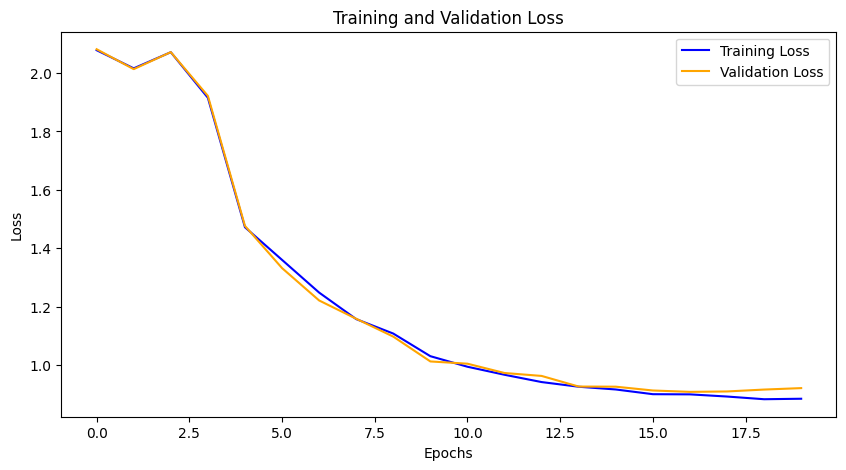

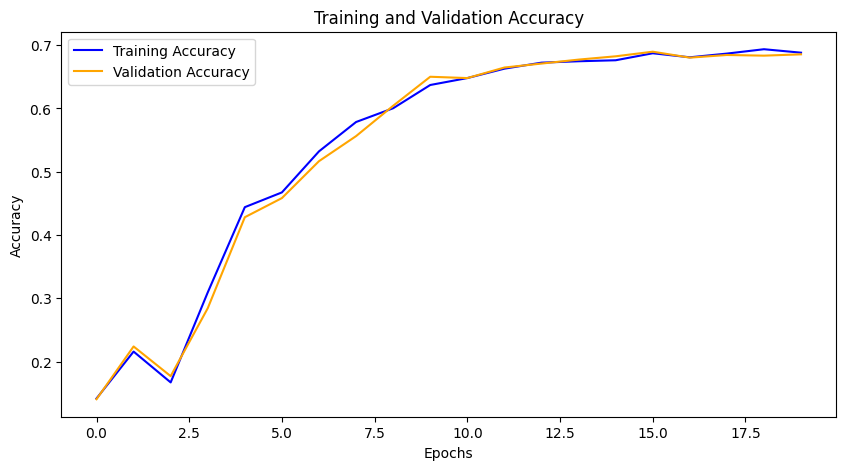

--------------Test Set--------------
Loss :  0.8879885028914324
Model and outputs saved to - /content/drive/MyDrive/cnn_blood_type/model_with_outputs.pkl.


In [ ]:
if __name__ == '__main__':
    main()